In [2]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from sklearn.decomposition import PCA, FastICA
import os
import random
from enum import Enum
from pathlib import Path

In [3]:
ROOT_DIR = "/data" if Path("/data").exists() else "."
ROOT_DIR = f"{ROOT_DIR}/figures"
Path(ROOT_DIR).mkdir(exist_ok=True)

In [4]:
def set_seeds(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

## Config

In [5]:
class Dataset(Enum):
    mnist = "mnist"
    cifar10 = "cifar10"


class DatasetType(Enum):
    original = "original"
    standardised = "standardised"
    poorly_scaled = "poorly-scaled"
    centred = "centred"


@dataclass
class Config:
    patch_size = 11
    num_filters = 32
    batch_size = 128
    epochs = 3
    dataset = Dataset.cifar10
    dataset_type = DatasetType.standardised

    @property
    def kernel_shape(self):
        return (self.patch_size, self.patch_size, self.n_channels, self.num_filters)

    @property
    def n_channels(self):
        return 1 if self.dataset == Dataset.mnist else 3

    @property
    def prefix(self):
        return f"{self.dataset.value}_p{self.patch_size}_{self.dataset_type.value}"


config = Config()
set_seeds(0)

## Functions

In [6]:
# comment out if latex support is not installed

import matplotlib as mpl
mpl.use('pgf')
from math import sqrt
default_width = 5.78853 
default_ratio = (sqrt(5.0) - 1.0) / 2.0 
mpl.rcParams["text.usetex"] = True
mpl.rcParams["pgf.texsystem"] = "pdflatex"
mpl.rcParams["pgf.rcfonts"] = False
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.sans-serif"] = []
mpl.rcParams["font.monospace"] = []
mpl.rcParams["figure.figsize"] = [default_width, default_width * default_ratio]
%matplotlib inline
plt.close("all")

In [7]:
def normalise(a):
    return np.squeeze((a - np.min(a)) / np.ptp(a))


def plot_components(kernel, n_cols=8, show=True, name=None):
    shape = tf.shape(kernel)
    n_filters = shape[-1]
    n_cols = min(n_filters, n_cols)
    n_rows = int(np.ceil(n_filters / n_cols))
    plt.figure(figsize=(n_cols, n_rows))

    for i in range(n_filters):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(
            normalise(np.squeeze(kernel[..., i])),
            cmap=plt.cm.gray_r,
            interpolation="nearest",
        )
        plt.xticks(())
        plt.yticks(())

    plt.tight_layout()
    if name:
        plt.savefig(f"{ROOT_DIR}/{name}.jpg", dpi=300)

    if show:
        plt.show()

    return plt


class Orthogonal(tf.keras.regularizers.Regularizer):
    def __init__(self, gain=1.0, diag=True, axis=0):
        self.gain = gain
        self.diag = diag
        self.axis = axis

    def __call__(self, w):
        wf = tf.reshape(w, (-1, w.shape[-1]))
        if self.axis == 1:
            wf = tf.transpose((wf))
        if self.diag:
            dw = self.gain * tf.reduce_sum(
                tf.square(
                    tf.matmul(wf, wf, transpose_a=True)
                    - tf.eye(wf.shape[-1], wf.shape[-1])
                )
            )
        else:
            wf2 = tf.matmul(wf, wf, transpose_a=True)
            dw = self.gain * tf.reduce_sum(
                tf.square(wf2 - tf.linalg.band_part(wf2, 0, 0))
            )
        return dw

    def get_config(self):
        return {"gain": self.gain}

In [8]:
def plot_and_save(kernel, name):
    plot_components(kernel, name=f"{config.prefix}__{name}")


class ModelBase(keras.Model):
    def __init__(self, dense, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.dense = dense

    def call(self, inputs):
        return self.dense(inputs)

    def plot_filters(self, name=None, sort=False, sort_by="sigma"):
        kernel = tf.reshape(self.dense.kernel, config.kernel_shape)
        if sort:
            if hasattr(self.dense, sort_by):
                d = getattr(self.dense, sort_by)
                indices = tf.argsort(d, direction="DESCENDING")
                kernel = tf.gather(kernel, indices, axis=3)
            else:
                raise Exception("sort by not found")

        plot_components(kernel, name=name or f"{config.prefix}__{self.name}")


class ModelCustomGradient(ModelBase):
    def train_step(self, data):
        y = self(data, training=True)
        dw = self.dense.compute_gradient(data, y)
        self.optimizer.apply_gradients(zip([dw], [self.dense.kernel]))
        return {m.name: m.result() for m in self.metrics}


class ModelCustom(ModelBase):
    def train_step(self, data):
        with tf.GradientTape() as tape:
            y = self.dense(data, training=True)
            loss = tf.reduce_sum(self.dense.losses)
        grad = tape.gradient(loss, self.dense.trainable_weights)
        self.optimizer.apply_gradients(zip(grad, self.dense.trainable_weights))
        metrics = {m.name: m.result() for m in self.metrics}
        metrics["loss"] = loss
        return metrics


class PlotFilters(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        self.model.plot_filters()


class PrintSigma(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print(self.model.dense.sigma)

## Prepare dataset

In [9]:
def load_dataset(config, n=500):
    stride = 1
    if config.dataset == Dataset.mnist:
        (x_train, _), (_, _) = keras.datasets.mnist.load_data()
        x_train = np.expand_dims(x_train, -1).astype("float32") / 255

    else:
        (x_train, _), (_, _) = keras.datasets.cifar10.load_data()
        x_train = x_train.astype("float32") / 255
    size = config.patch_size
    n_filters = config.num_filters
    n_channels = config.n_channels
    patches = tf.image.extract_patches(
        x_train[:n],
        sizes=[1, size, size, 1],
        strides=[1, stride, stride, 1],
        rates=[1, 1, 1, 1],
        padding="SAME",
    )
    data = tf.reshape(patches, (-1, size * size * n_channels))

    if config.dataset_type == DatasetType.original:
        ds = (
            tf.data.Dataset.from_tensor_slices(data)
            .shuffle(10000, reshuffle_each_iteration=True)
            .batch(config.batch_size)
        )
    elif config.dataset_type == DatasetType.poorly_scaled:
        ds = (
            tf.data.Dataset.from_tensor_slices(100 * data + 100.0)
            .shuffle(10000, reshuffle_each_iteration=True)
            .batch(config.batch_size)
        )
    elif config.dataset_type == DatasetType.standardised:
        mean = tf.reduce_mean(data, axis=0, keepdims=True)
        std = tf.sqrt(1e-3 + tf.math.reduce_variance(data, axis=0, keepdims=True))
        data = (data - mean) / std
        ds = (
            tf.data.Dataset.from_tensor_slices(data)
            .shuffle(10000, reshuffle_each_iteration=True)
            .batch(config.batch_size)
        )
    elif config.dataset_type == DatasetType.centred:
        mean = tf.reduce_mean(data, axis=0, keepdims=True)
        data = data - mean
        ds = (
            tf.data.Dataset.from_tensor_slices(data)
            .shuffle(10000, reshuffle_each_iteration=True)
            .batch(config.batch_size)
        )
    return ds, data

In [10]:
ds, data = load_dataset(config)

170498071/170498071 [==============================] - 72s 0us/step


In [11]:
data.shape

TensorShape([512000, 363])

# Linear

## PCA via SVD

PCA via SVD of the data. The input data is centred for each feature before applying the SVD.

In [12]:
name = "pca-svd"

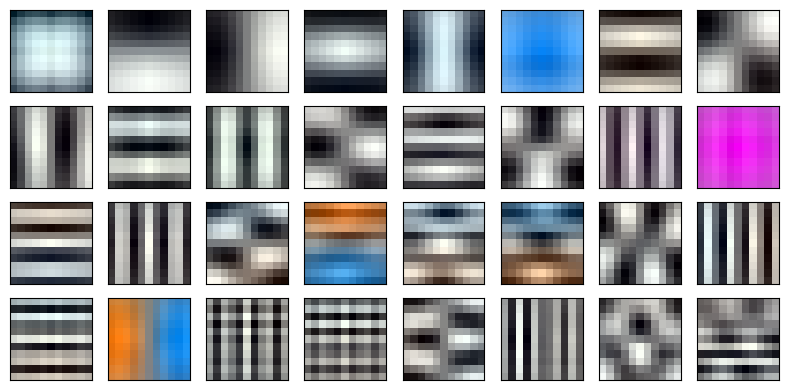

In [13]:
pca = PCA(config.num_filters).fit(data)
kernel = tf.reshape(pca.components_.T, config.kernel_shape)
plot_and_save(kernel, name=name)

## Linear autoencoder

In [14]:
name = "pca-ae"

\begin{align*}
\mathcal{L}(\mathbf{W}) & = \mathbb{E}(||\mathbf{x} - \mathbf{x}\mathbf{W}\mathbf{W}^T||^2_2)
\end{align*}

In [15]:
class RecDense(layers.Dense):
    def call(self, inputs, training=None):
        if training is None:
            training = keras.backend.learning_phase()
        y = tf.matmul(inputs, self.kernel)
        if training:
            loss_linear = tf.reduce_mean(
                tf.reduce_sum(
                    tf.square(tf.matmul(y, self.kernel, transpose_b=True) - inputs),
                    axis=1,
                )
            )
            self.add_loss(loss_linear)

        if self.use_bias:
            y += self.bias
        return y

Epoch 1/3
4000/4000 [==============================] - 4s 935us/step - loss: 25.8763
Epoch 2/3
4000/4000 [==============================] - 4s 928us/step - loss: 19.7918
Epoch 3/3
4000/4000 [==============================] - 4s 930us/step - loss: 19.7592


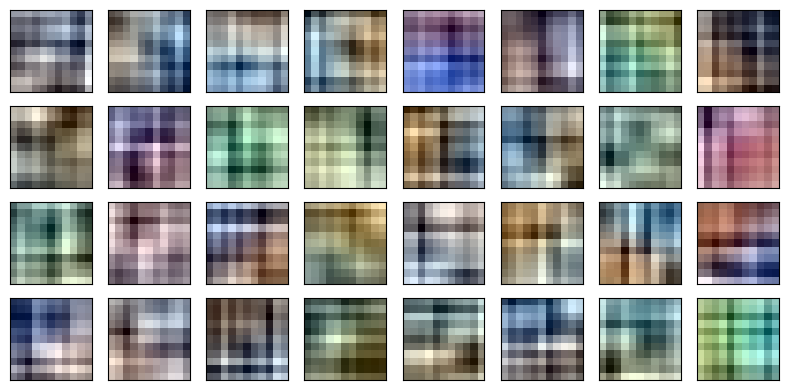

In [16]:
tf.keras.backend.clear_session()

dense = RecDense(
    config.num_filters,
    use_bias=False,
)
model = ModelCustom(dense=dense, name=name)
model.compile(keras.optimizers.Adam())
model.fit(ds, epochs=config.epochs)
model.plot_filters()

## Weighted subspace algorithm with unit norm

In [17]:
name = "pca-ae-weighted-subspace-unit-norm"

\begin{align*}
    \mathcal{L}(\mathbf{W}) &=\mathbb{E}(||\mathbf{x}[\mathbf{W}]_{sg}\mathbf{W}^T-\mathbf{x}||^2_2 \\
     &+   ||\mathbf{W}\hat{\mathbf{\Sigma}}\mathbf{\Lambda}^{\frac{1}{2}}||^2_2-||\mathbf{W}\hat{\mathbf{\Sigma}}||^2_2 \\&- ||\mathbf{xW}\mathbf{\Lambda}^{\frac{1}{2}}||^2_2 + ||\mathbf{xW}||^2_2)
\end{align*}

In [18]:
class RecDense(layers.Dense):
    def build(self, input_shape):
        super().build(input_shape)
        self.var = self.add_weight(
            "var", shape=self.units, initializer="ones", trainable=False
        )
        self.scale = tf.linspace(0.05, 1.0, num=tf.shape(self.kernel)[1])[::-1]
        self.var.assign(self.scale)

    @property
    def lambda_(self):
        return self.scale

    def call(self, inputs, training=None):
        if training is None:
            training = keras.backend.learning_phase()
        inputs = inputs - tf.reduce_mean(inputs, axis=0)
        y = tf.matmul(inputs, self.kernel)

        if training:
            var = tf.stop_gradient(tf.math.reduce_variance(y, axis=0))
            self.var.assign_add(0.01 * (-self.var + var))
            loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.square(
                        tf.matmul(tf.stop_gradient(y), self.kernel, transpose_b=True)
                        - inputs
                    ),
                    axis=1,
                )
            )

            s = var * (self.lambda_ - 1)
            loss += -tf.reduce_sum(
                tf.reduce_mean(tf.square(y) * (self.lambda_), axis=0)
            ) + tf.reduce_mean(tf.reduce_sum(tf.square(y), axis=1), axis=0)

            loss += tf.reduce_sum(tf.square(self.kernel) * s)
            self.add_loss(loss)

        if self.use_bias:
            y += self.bias
        return y

Epoch 1/3
3957/4000 [============================>.] - ETA: 0s - loss: 28.5077

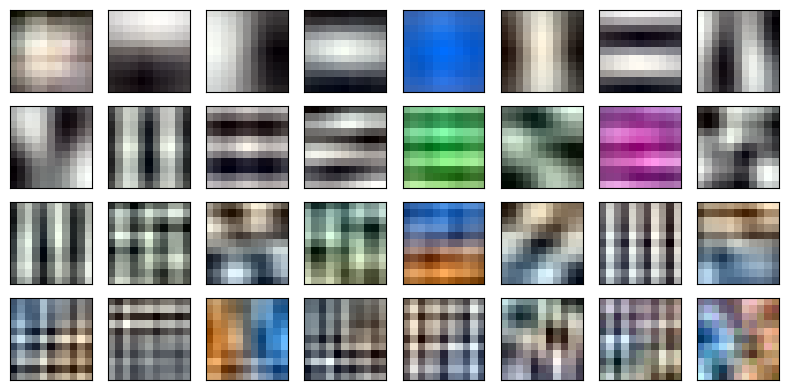

4000/4000 [==============================] - 6s 1ms/step - loss: 28.4213
Epoch 2/3
3983/4000 [============================>.] - ETA: 0s - loss: 20.6375

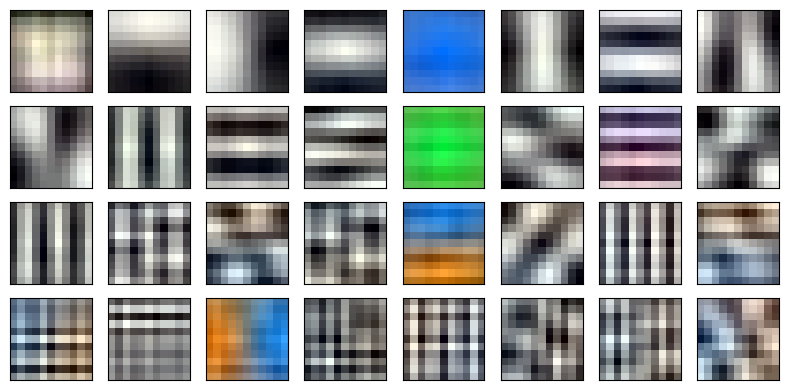

4000/4000 [==============================] - 6s 2ms/step - loss: 20.6326
Epoch 3/3
3960/4000 [============================>.] - ETA: 0s - loss: 20.4977

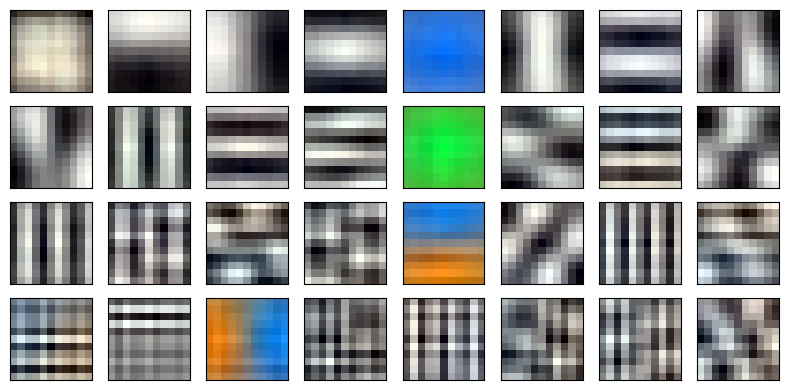

4000/4000 [==============================] - 5s 1ms/step - loss: 20.4943


In [19]:
tf.keras.backend.clear_session()
dense = RecDense(
    config.num_filters,
    kernel_constraint=keras.constraints.UnitNorm([0]),
    use_bias=False,
)
model = ModelCustom(dense=dense, name=name)
model.compile(keras.optimizers.Adam(1e-3))
model.fit(ds, epochs=config.epochs, callbacks=[PlotFilters()])

In [20]:
tf.reduce_sum(tf.square(dense.kernel), axis=0)

<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([0.99999976, 0.9999997 , 0.99999976, 0.9999999 , 0.9999998 ,
       0.99999994, 0.9999997 , 0.99999976, 0.9999999 , 0.9999998 ,
       0.99999976, 0.9999997 , 0.9999995 , 0.9999999 , 0.9999997 ,
       0.99999994, 0.99999964, 0.9999999 , 0.9999999 , 0.99999994,
       0.9999996 , 0.9999998 , 0.99999976, 0.99999946, 0.99999976,
       1.        , 0.99999976, 0.9999997 , 0.9999998 , 0.9999997 ,
       0.99999964, 0.99999994], dtype=float32)>

# Nonlinear PCA

## Conventional without whitening


In [21]:
name = "nlpca-conventional"

\begin{align*}
    \mathcal{L}(\mathbf{W})  = \mathbb{E}(|| \mathbf{x} -  h(\mathbf{x}\mathbf{W})  \mathbf{W}^T  ||^2_2)
\end{align*}


In [22]:
tf.keras.backend.clear_session()


class RecDense(layers.Dense):
    def call(self, inputs, training=None):
        if training is None:
            training = keras.backend.learning_phase()

        kernel = self.kernel
        y = tf.matmul(inputs, kernel)
        mean = tf.math.reduce_mean(y, axis=0)

        y = y - mean
        yr = tf.nn.tanh(y)

        if training:
            loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.square(
                        tf.matmul(yr, (kernel), transpose_b=True)
                        - inputs
                        + tf.reduce_mean(inputs, axis=0)
                    ),
                    axis=1,
                )
            )

            self.add_loss(loss)

        if self.use_bias:
            y += self.bias
        return y

Epoch 1/3
4000/4000 [==============================] - 5s 1ms/step - loss: 133.4742
Epoch 2/3
4000/4000 [==============================] - 4s 1ms/step - loss: 132.8192
Epoch 3/3
4000/4000 [==============================] - 4s 1ms/step - loss: 132.8407


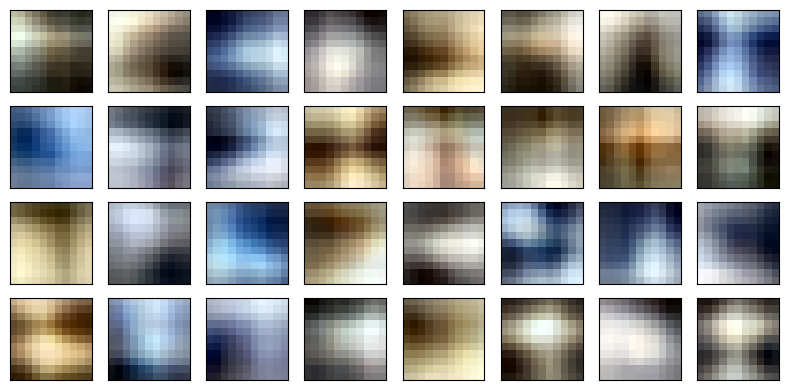

In [23]:
tf.keras.backend.clear_session()

dense = RecDense(
    config.num_filters,
    kernel_constraint=keras.constraints.UnitNorm([0]),
    use_bias=False,
)
model = ModelCustom(dense=dense, name=name)
model.compile(tf.keras.optimizers.Adam(1e-2))
model.fit(ds, epochs=config.epochs)
model.plot_filters()

## Trainable $\boldsymbol{\sigma}$ - without stop gradient


In [24]:
name = "nlpca-diff-no-sg"

\begin{align*}
    \mathcal{L}(\mathbf{W}, \mathbf{\Sigma}) & = \mathbb{E}(|| \mathbf{x} -  h(\mathbf{x}\mathbf{W}\mathbf{\Sigma}^{-1}) \mathbf{\Sigma} \mathbf{W}^T  ||^2_2)
\end{align*}


In [25]:
tf.keras.backend.clear_session()


class RecDense(layers.Dense):
    def build(self, input_shape):
        super().build(input_shape)

        self.sigma = self.add_weight(
            "sigma", shape=self.units, initializer="ones", trainable=False
        )

    def call(self, inputs, training=None):
        if training is None:
            training = keras.backend.learning_phase()

        kernel = self.kernel
        y = tf.matmul(inputs, kernel)
        mean = tf.math.reduce_mean(y, axis=0)

        y = y - mean

        yr = self.sigma * tf.nn.tanh(y / self.sigma)

        if training:
            loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.square(
                        tf.matmul(yr, (kernel), transpose_b=True)
                        - inputs
                        + tf.reduce_mean(inputs, axis=0)
                    ),
                    axis=1,
                )
            )

            self.add_loss(loss)

        if self.use_bias:
            y += self.bias
        return y

Epoch 1/3
4000/4000 [==============================] - 5s 1ms/step - loss: 133.3979
Epoch 2/3
4000/4000 [==============================] - 4s 1ms/step - loss: 132.8888
Epoch 3/3
4000/4000 [==============================] - 4s 1ms/step - loss: 132.8514


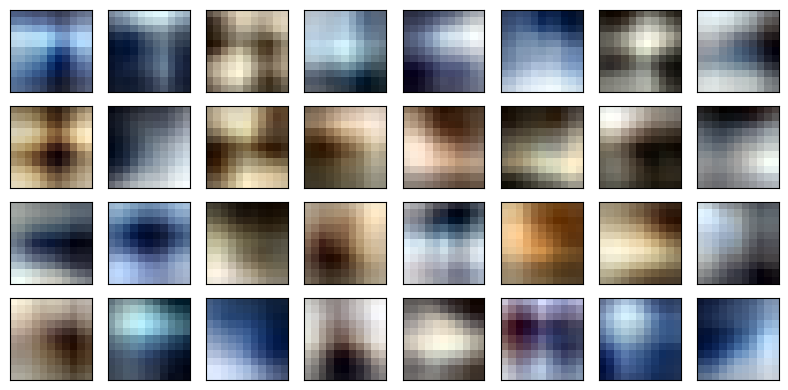

In [26]:
tf.keras.backend.clear_session()

dense = RecDense(
    config.num_filters,
    kernel_constraint=keras.constraints.UnitNorm([0]),
    use_bias=False,
)
model = ModelCustom(dense=dense, name=name)
model.compile(tf.keras.optimizers.Adam(1e-2))
model.fit(ds, epochs=config.epochs)
model.plot_filters(sort=True)

## Trainable $\boldsymbol{\sigma}$


In [27]:
name = "nlpca-diff"

\begin{align*}
    \mathcal{L}(\mathbf{W}, \mathbf{\Sigma}) & = \mathbb{E}(|| \mathbf{x} -  h(\mathbf{x}\mathbf{W}\mathbf{\Sigma}^{-1}) \mathbf{\Sigma} [\mathbf{W}^T ]_{sg} ||^2_2)
\end{align*}


In [28]:
tf.keras.backend.clear_session()


class RecDense(layers.Dense):
    def __init__(self, *args, adaptive_scale=False, sigma_regularizer=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.adaptive_scale = adaptive_scale
        self.sigma_regularizer = sigma_regularizer

    def build(self, input_shape):
        super().build(input_shape)

        self.sigma = self.add_weight(
            "sigma",
            shape=self.units,
            initializer="ones",
            trainable=True,
            regularizer=self.sigma_regularizer,
        )

    def call(self, inputs, training=None):
        if training is None:
            training = keras.backend.learning_phase()

        kernel = self.kernel
        y = tf.matmul(inputs, kernel)
        mean = tf.math.reduce_mean(y, axis=0)

        y = y - mean

        out_std = tf.stop_gradient(tf.reduce_mean(tf.math.reduce_std(y, axis=1)))
        sigma = out_std * self.sigma if self.adaptive_scale else self.sigma
        yr = sigma * tf.nn.tanh(y / sigma)

        if training:
            loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.square(
                        tf.matmul(yr, tf.stop_gradient(kernel), transpose_b=True)
                        - inputs
                        + tf.reduce_mean(inputs, axis=0)
                    ),
                    axis=1,
                )
            )

            self.add_loss(loss)

        if self.use_bias:
            y += self.bias
        return y

Epoch 1/3
4000/4000 [==============================] - 5s 1ms/step - loss: 48.3775
Epoch 2/3
4000/4000 [==============================] - 4s 1ms/step - loss: 32.0007
Epoch 3/3
4000/4000 [==============================] - 4s 1ms/step - loss: 31.1417


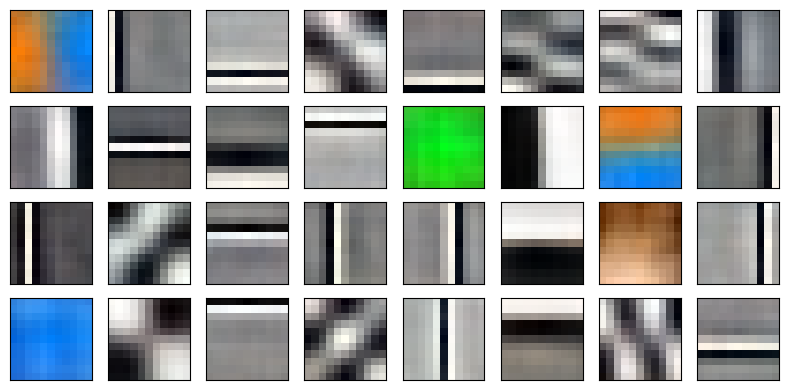

In [29]:
tf.keras.backend.clear_session()

dense = RecDense(
    config.num_filters,
    kernel_constraint=keras.constraints.UnitNorm([0]),
    sigma_regularizer=keras.regularizers.l2(1e-3),
    adaptive_scale=False,
    use_bias=False,
)
model = ModelCustom(dense=dense, name=name)
model.compile(tf.keras.optimizers.Adam(1e-2))
model.fit(ds, epochs=config.epochs)
model.plot_filters(sort=False)

### Run for longer, without l2 reg, to show how filters degenerate as sigma keeps increasing

Epoch 1/10
3962/4000 [============================>.] - ETA: 0s - loss: 46.6983

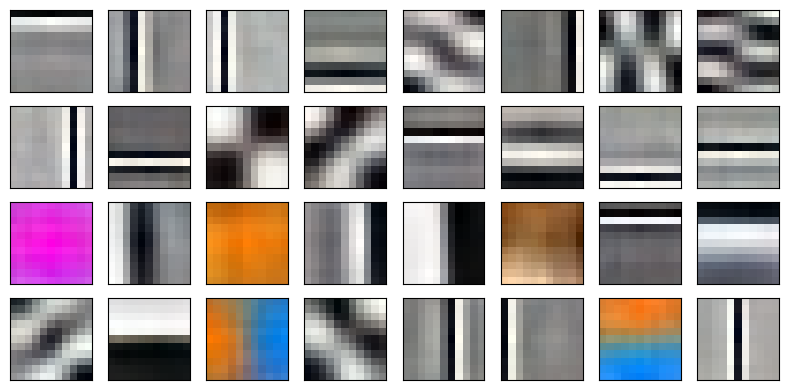

<tf.Variable 'rec_dense/sigma:0' shape=(32,) dtype=float32, numpy=
array([ 9.997033 ,  9.55279  ,  6.1205077,  8.374558 ,  5.2280846,
        9.491663 ,  5.2627134,  4.253823 , 11.838943 ,  9.219666 ,
        9.921183 ,  7.7573934, 10.548313 , 12.060184 ,  8.167693 ,
        7.7462816, 11.4746   , 12.77544  , 10.146028 , 13.57788  ,
       19.662264 , 27.204979 , 13.123578 , 14.380332 ,  5.6682243,
       22.08911  ,  6.046314 ,  7.5803823,  8.07922  ,  8.07031  ,
        7.4268193, 17.97228  ], dtype=float32)>
4000/4000 [==============================] - 6s 2ms/step - loss: 46.5256
Epoch 2/10
3969/4000 [============================>.] - ETA: 0s - loss: 24.9316

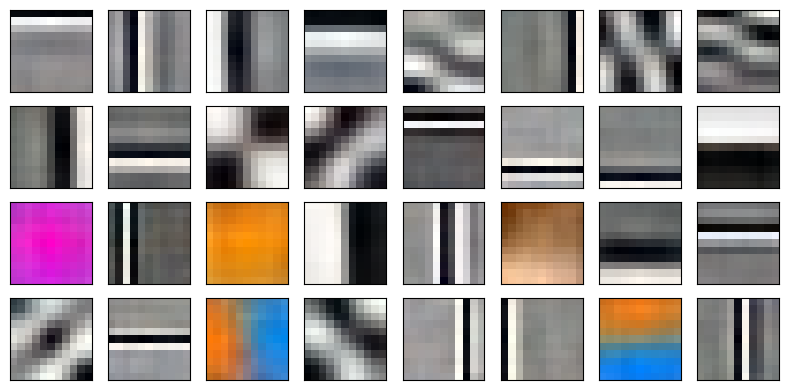

<tf.Variable 'rec_dense/sigma:0' shape=(32,) dtype=float32, numpy=
array([18.064814 , 15.504084 , 19.046658 , 24.135271 ,  8.353678 ,
       16.9244   ,  8.322257 ,  7.0762444, 17.406265 , 15.325566 ,
       14.756205 , 12.466914 , 16.437172 , 17.267014 , 16.615612 ,
       31.899939 , 12.429077 , 21.93986  , 20.643827 , 30.6767   ,
       31.177313 , 41.853176 , 16.925968 , 29.94085  ,  9.363706 ,
       22.959776 ,  9.790361 , 12.147064 , 14.777147 , 17.05813  ,
       11.900577 , 18.16289  ], dtype=float32)>
4000/4000 [==============================] - 6s 1ms/step - loss: 24.9122
Epoch 3/10
3986/4000 [============================>.] - ETA: 0s - loss: 22.0672

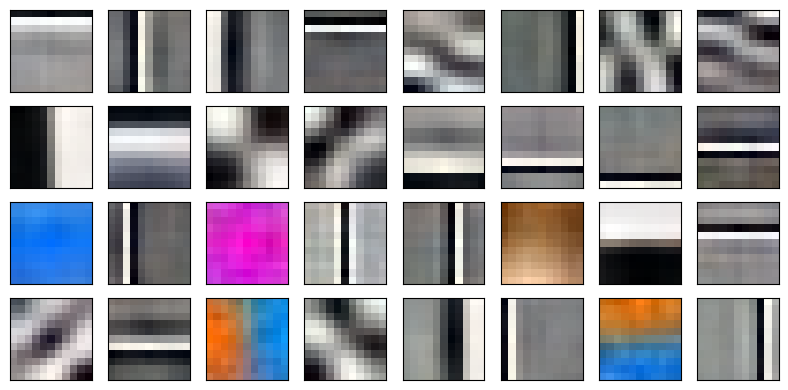

<tf.Variable 'rec_dense/sigma:0' shape=(32,) dtype=float32, numpy=
array([26.508356 , 23.967062 , 31.000145 , 25.412012 , 12.097908 ,
       24.71079  , 12.312283 , 10.71988  , 42.275818 , 34.08514  ,
       21.361734 , 18.176744 , 30.948734 , 20.803398 , 24.423351 ,
       34.258656 , 26.014582 , 22.860214 , 23.073214 , 38.570404 ,
       31.39958  , 58.07127  , 42.41501  , 30.385801 , 14.1450405,
       24.525312 , 14.268225 , 17.771927 , 30.785984 , 24.25439  ,
       17.188314 , 19.797441 ], dtype=float32)>
4000/4000 [==============================] - 6s 1ms/step - loss: 22.0636
Epoch 4/10
3960/4000 [============================>.] - ETA: 0s - loss: 21.2912

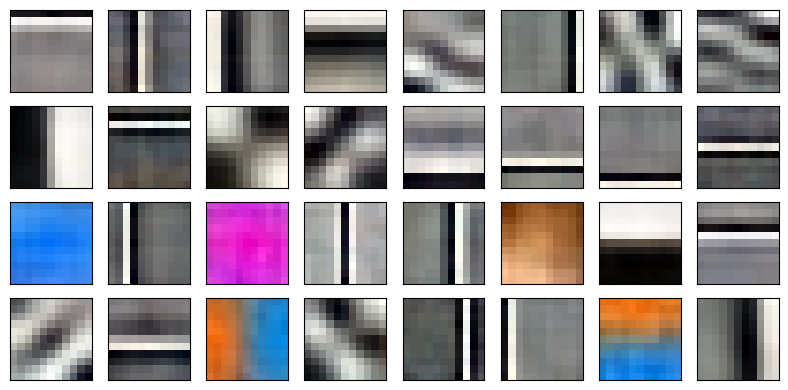

<tf.Variable 'rec_dense/sigma:0' shape=(32,) dtype=float32, numpy=
array([35.89594  , 34.45532  , 42.44774  , 42.395737 , 17.23666  ,
       33.628586 , 17.443634 , 15.3153105, 59.02294  , 41.423553 ,
       29.877558 , 25.349031 , 43.388878 , 27.750753 , 32.857243 ,
       34.723232 , 35.441906 , 28.691843 , 24.956816 , 38.739655 ,
       33.734303 , 76.73255  , 58.629513 , 33.644733 , 20.010366 ,
       31.547333 , 19.679338 , 24.729292 , 38.74587  , 32.544495 ,
       23.308865 , 34.67638  ], dtype=float32)>
4000/4000 [==============================] - 6s 2ms/step - loss: 21.2848
Epoch 5/10
3971/4000 [============================>.] - ETA: 0s - loss: 21.1624

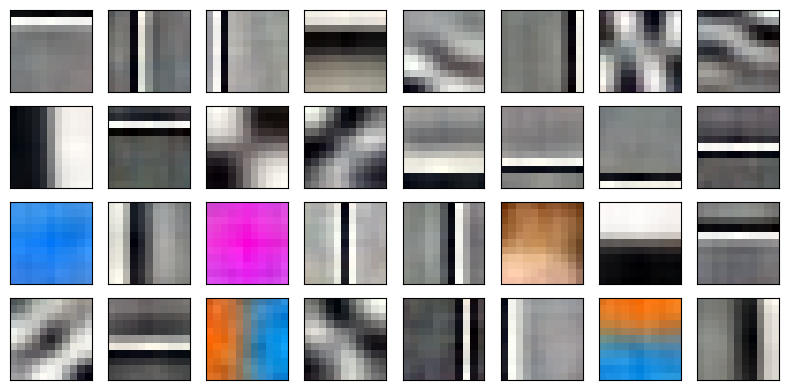

<tf.Variable 'rec_dense/sigma:0' shape=(32,) dtype=float32, numpy=
array([45.98105 , 43.82734 , 50.10672 , 57.77793 , 23.186638, 43.759453,
       23.19956 , 20.824486, 77.127495, 42.634624, 40.545048, 33.58114 ,
       54.878147, 40.100426, 42.23274 , 37.02964 , 45.12252 , 49.66954 ,
       30.956106, 39.741074, 41.43539 , 97.66586 , 76.94676 , 42.725235,
       27.384   , 42.89417 , 26.027372, 33.11015 , 39.556824, 45.985245,
       30.512081, 49.041103], dtype=float32)>
4000/4000 [==============================] - 6s 1ms/step - loss: 21.1582
Epoch 6/10
3994/4000 [============================>.] - ETA: 0s - loss: 22.9990

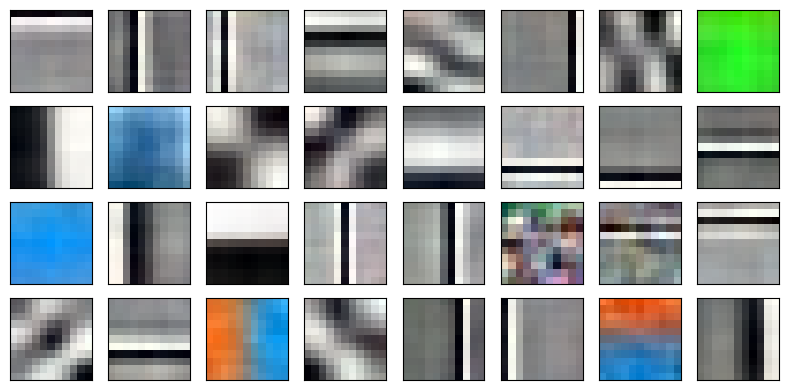

<tf.Variable 'rec_dense/sigma:0' shape=(32,) dtype=float32, numpy=
array([61.779224, 54.708244, 50.83708 , 83.42802 , 29.177185, 54.47136 ,
       24.933922, 27.6686  , 97.15295 , 75.96126 , 52.652313, 42.178493,
       71.991776, 44.318066, 50.136017, 46.399075, 55.306454, 65.90393 ,
       64.40243 , 44.349655, 53.323425, 99.07669 , 78.29827 , 49.726357,
       32.48068 , 52.200653, 28.700275, 41.464123, 47.147957, 56.040325,
       37.142323, 62.070538], dtype=float32)>
4000/4000 [==============================] - 6s 2ms/step - loss: 22.9967
Epoch 7/10
3980/4000 [============================>.] - ETA: 0s - loss: 24.7822

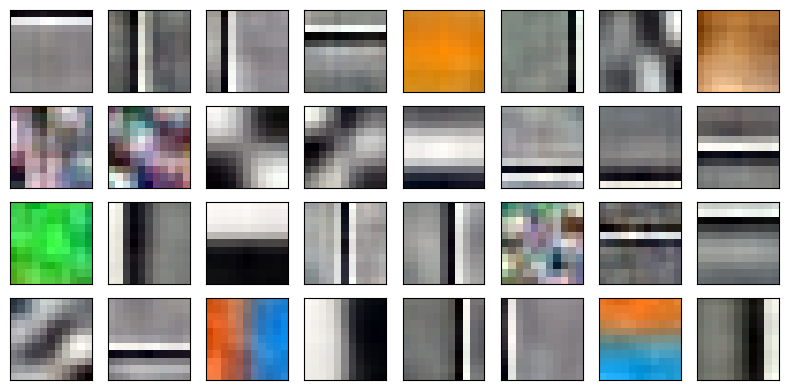

<tf.Variable 'rec_dense/sigma:0' shape=(32,) dtype=float32, numpy=
array([ 69.33242 ,  64.36127 ,  59.321877,  83.6371  ,  39.447124,
        62.668983,  29.985262,  57.80094 , 100.43593 ,  79.91892 ,
        58.429718,  48.464764,  85.47971 ,  51.099728,  60.73611 ,
        59.465378,  58.46836 ,  80.7531  ,  83.528206,  52.860172,
        64.46276 ,  99.063614,  78.41396 ,  65.82201 ,  34.060062,
        58.897602,  31.02758 ,  74.306725,  57.321075,  63.36947 ,
        41.96781 ,  74.11322 ], dtype=float32)>
4000/4000 [==============================] - 6s 1ms/step - loss: 24.7649
Epoch 8/10
3965/4000 [============================>.] - ETA: 0s - loss: 23.1368

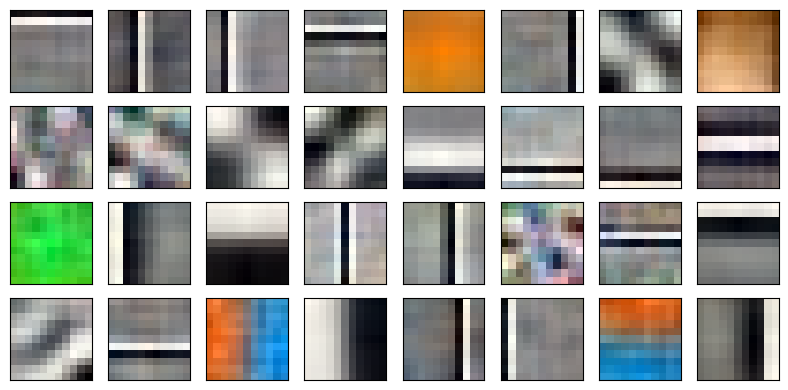

<tf.Variable 'rec_dense/sigma:0' shape=(32,) dtype=float32, numpy=
array([ 75.54284 ,  77.957985,  76.11834 ,  84.36428 ,  50.286396,
        70.42178 ,  41.30556 ,  76.89442 , 100.307106,  79.9062  ,
        68.64674 ,  53.630226,  96.7415  ,  58.973732,  71.60739 ,
        72.83566 ,  59.256493,  94.78149 , 104.15934 ,  61.487167,
        77.140236,  98.96245 ,  78.62993 ,  84.166176,  38.26022 ,
        71.78005 ,  36.383595,  94.731804,  67.85067 ,  74.39768 ,
        47.21463 ,  86.74252 ], dtype=float32)>
4000/4000 [==============================] - 6s 1ms/step - loss: 23.1218
Epoch 9/10
3962/4000 [============================>.] - ETA: 0s - loss: 25.5834

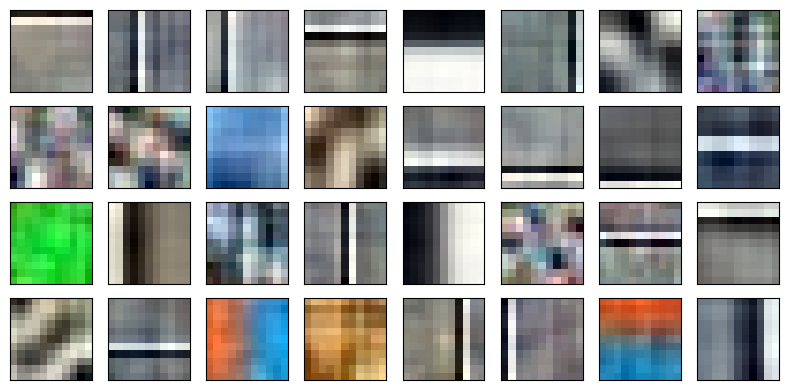

<tf.Variable 'rec_dense/sigma:0' shape=(32,) dtype=float32, numpy=
array([ 83.377304,  85.58517 ,  86.0709  ,  86.989586,  71.50028 ,
        74.98716 ,  49.367287,  89.44134 ,  99.255196,  79.67612 ,
        93.46413 ,  57.904232, 105.85753 ,  67.89285 ,  80.452705,
        80.622   ,  61.68822 , 109.200134, 117.951805,  67.166176,
        98.08388 ,  98.08098 ,  78.11757 ,  93.1867  ,  40.891537,
        77.47277 ,  39.302643, 108.154625,  73.85244 ,  79.4807  ,
        51.120632,  96.36484 ], dtype=float32)>
4000/4000 [==============================] - 6s 1ms/step - loss: 25.5604
Epoch 10/10
3978/4000 [============================>.] - ETA: 0s - loss: 27.8770

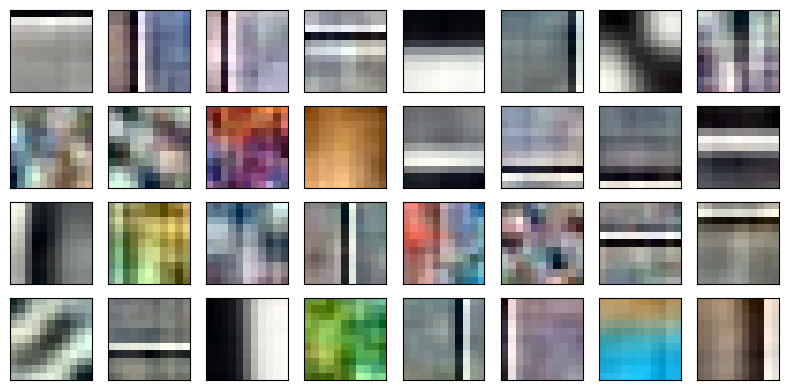

<tf.Variable 'rec_dense/sigma:0' shape=(32,) dtype=float32, numpy=
array([ 88.099236,  87.79006 ,  86.67902 ,  88.27553 ,  93.68155 ,
        81.2652  ,  53.7882  ,  89.40464 ,  98.24352 ,  78.8365  ,
        97.63564 ,  93.29472 , 113.250694,  70.0743  ,  84.93749 ,
        88.52807 ,  90.33385 , 109.8043  , 117.88521 ,  67.915764,
       102.995   ,  96.7933  ,  77.38999 ,  95.13255 ,  43.002045,
        79.85861 ,  68.24983 , 107.85567 ,  79.86783 ,  80.88331 ,
        55.956398,  99.30675 ], dtype=float32)>
4000/4000 [==============================] - 6s 1ms/step - loss: 27.8505


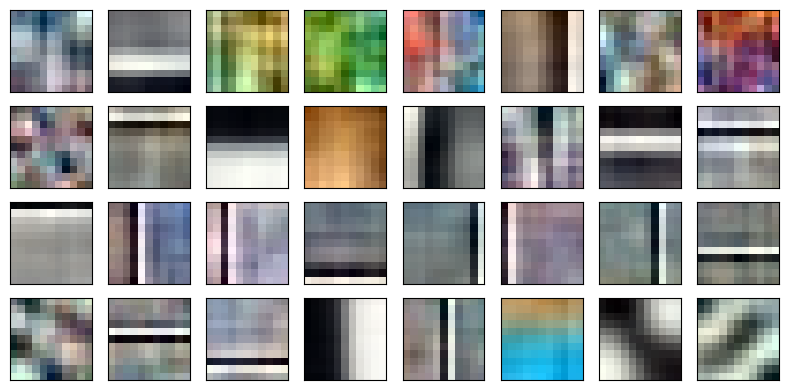

In [30]:
epochs = 10
tf.keras.backend.clear_session()
dense = RecDense(
    config.num_filters,
    adaptive_scale=False,
    kernel_constraint=keras.constraints.UnitNorm([0]),
    # sigma_regularizer=keras.regularizers.l2(1e-3),
    use_bias=False,
)
model = ModelCustom(dense=dense, name=name + f"-reg-e{epochs}")
model.compile(tf.keras.optimizers.Adam(1e-2))
model.fit(ds, epochs=epochs, callbacks=[PlotFilters(), PrintSigma()])
model.plot_filters(sort=True, sort_by="sigma")

In [31]:
dense.sigma

<tf.Variable 'rec_dense/sigma:0' shape=(32,) dtype=float32, numpy=
array([ 88.099236,  87.79006 ,  86.67902 ,  88.27553 ,  93.68155 ,
        81.2652  ,  53.7882  ,  89.40464 ,  98.24352 ,  78.8365  ,
        97.63564 ,  93.29472 , 113.250694,  70.0743  ,  84.93749 ,
        88.52807 ,  90.33385 , 109.8043  , 117.88521 ,  67.915764,
       102.995   ,  96.7933  ,  77.38999 ,  95.13255 ,  43.002045,
        79.85861 ,  68.24983 , 107.85567 ,  79.86783 ,  80.88331 ,
        55.956398,  99.30675 ], dtype=float32)>

## EMA $\boldsymbol{\sigma}$ - tanh

In [32]:
tf.keras.backend.clear_session()


class RecDense(layers.Dense):
    def build(self, input_shape):
        super().build(input_shape)
        self.moving_variance = self.add_weight(
            "var", shape=self.units, initializer="ones", trainable=False
        )

    def call(self, inputs, training=None):
        if training is None:
            training = keras.backend.learning_phase()
        kernel = self.kernel

        y = tf.matmul(inputs, kernel)
        if training:
            mean = tf.math.reduce_mean(y, axis=0)
            y = y - mean
            var = tf.math.reduce_variance(y, axis=0)
            self.moving_variance.assign_add(0.01 * (var - self.moving_variance))

            # std = tf.sqrt(1e-3+var)
            std = tf.sqrt(1e-3 + self.moving_variance)

            self.add_metric(tf.reduce_max(y), "max")
            self.add_metric(tf.reduce_min(y), "min")
            self.add_metric(tf.math.reduce_variance(y), "var")

            yr = std * self.activation(y / std)

            loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.square(
                        tf.matmul(yr, tf.stop_gradient(kernel), transpose_b=True)
                        - inputs
                        + tf.reduce_mean(inputs, axis=0)
                    ),
                    axis=1,
                )
            )
            self.add_loss(loss)

        if self.use_bias:
            y += self.bias
        return y

In [33]:
name = "nlpca-mean-std-tanh"

\begin{align*}
    \mathcal{L}(\mathbf{W}) & = \mathbb{E}(|| \mathbf{x} -  h(\mathbf{x}\mathbf{W}\mathbf{\Sigma}^{-1}) \mathbf{\Sigma} [\mathbf{W}^T ]_{sg} ||^2_2)\\ 
    h(x) &= \tanh(x) \\
\end{align*}

Epoch 1/3
3974/4000 [============================>.] - ETA: 0s - max: 29.9299 - min: -23.1528 - var: 10.8076 - loss: 82.4687

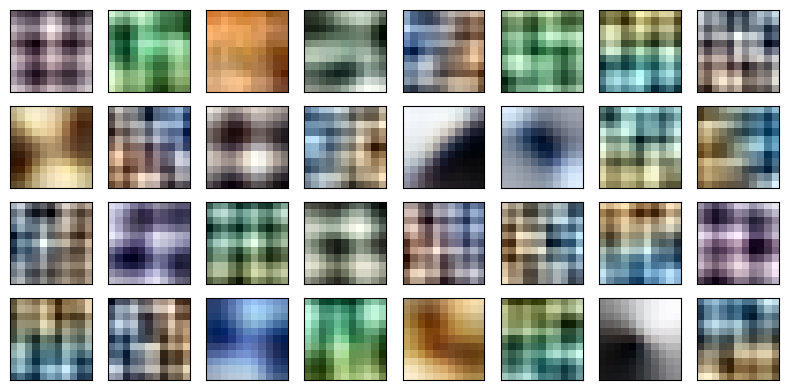

4000/4000 [==============================] - 7s 2ms/step - max: 29.9075 - min: -23.1620 - var: 10.8114 - loss: 82.4881
Epoch 2/3
3965/4000 [============================>.] - ETA: 0s - max: 30.2366 - min: -23.0841 - var: 10.5543 - loss: 82.9803

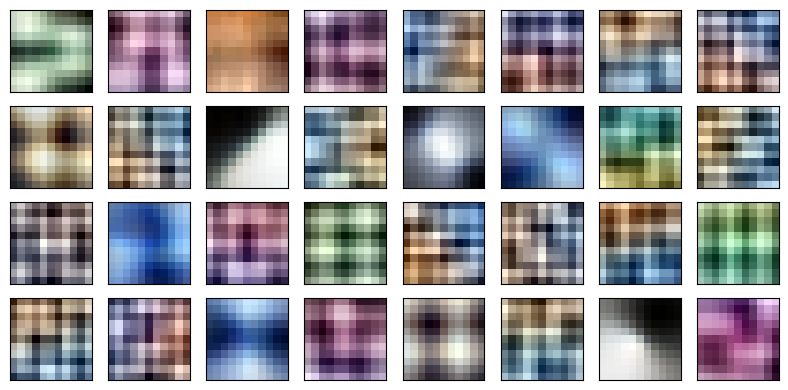

4000/4000 [==============================] - 6s 2ms/step - max: 30.2045 - min: -23.1005 - var: 10.5618 - loss: 83.0094
Epoch 3/3
3961/4000 [============================>.] - ETA: 0s - max: 30.2858 - min: -22.9977 - var: 10.5471 - loss: 83.0051

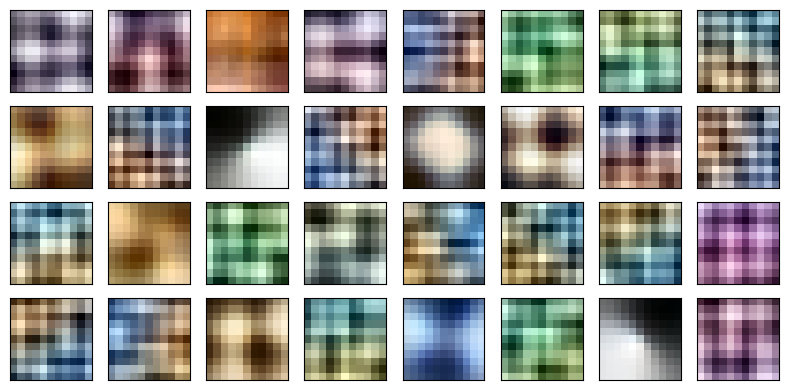

4000/4000 [==============================] - 6s 2ms/step - max: 30.2491 - min: -23.0152 - var: 10.5560 - loss: 83.0522


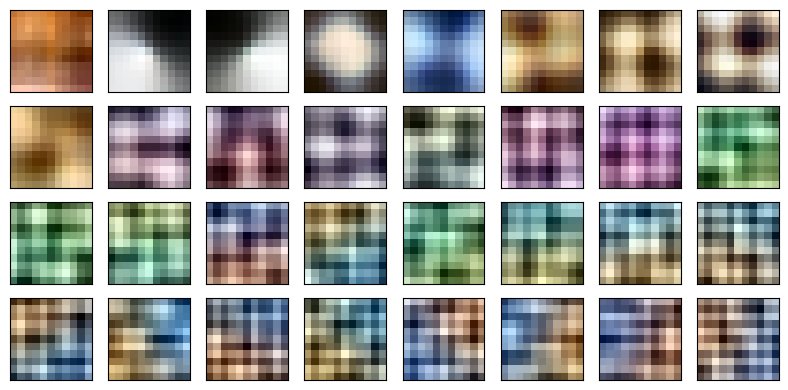

In [34]:
tf.keras.backend.clear_session()

dense = RecDense(
    config.num_filters,
    kernel_initializer=keras.initializers.Orthogonal(),
    activation=tf.nn.tanh,
    kernel_constraint=keras.constraints.UnitNorm([0]),
    use_bias=False,
)
model = ModelCustom(dense=dense, name=name)
model.compile(keras.optimizers.Adam(1e-2))
model.fit(ds, epochs=config.epochs, callbacks=[PlotFilters()])
model.plot_filters(sort_by="moving_variance", sort=True)

## EMA $\boldsymbol{\sigma}$ -  scaled tanh (main method)

In [35]:
name = "nlpca-mean-std-scaled-tanh"

\begin{align*}
    \mathcal{L}(\mathbf{W}) & = \mathbb{E}(|| \mathbf{x} -  h(\mathbf{x}\mathbf{W}\mathbf{\Sigma}^{-1}) \mathbf{\Sigma} [\mathbf{W}^T ]_{sg} ||^2_2)\\ 
    h(x) &= 4\tanh(\frac{x}{4}) \\
\end{align*}

In [36]:
tf.keras.backend.clear_session()


class RecDense(layers.Dense):
    def build(self, input_shape):
        super().build(input_shape)
        self.moving_variance = self.add_weight(
            "var", shape=self.units, initializer="ones", trainable=False
        )

    def call(self, inputs, training=None):
        if training is None:
            training = keras.backend.learning_phase()
        kernel = self.kernel

        y = tf.matmul(inputs, kernel)
        if training:
            mean = tf.math.reduce_mean(y, axis=0)
            y = y - mean
            var = tf.math.reduce_variance(y, axis=0)
            self.moving_variance.assign_add(0.01 * (var - self.moving_variance))

            # std = tf.sqrt(1e-3+var)
            std = tf.sqrt(1e-3 + self.moving_variance)

            self.add_metric(tf.reduce_max(y), "max")
            self.add_metric(tf.reduce_min(y), "min")
            self.add_metric(tf.math.reduce_variance(y), "var")

            yr = std * self.activation(y / std)

            loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.square(
                        tf.matmul(yr, tf.stop_gradient(kernel), transpose_b=True)
                        - inputs
                        + tf.reduce_mean(inputs, axis=0)
                    ),
                    axis=1,
                )
            )
            self.add_loss(loss)

        if self.use_bias:
            y += self.bias
        return y

Epoch 1/3
3984/4000 [============================>.] - ETA: 0s - max: 30.3219 - min: -25.9440 - var: 10.4075 - loss: 28.2258

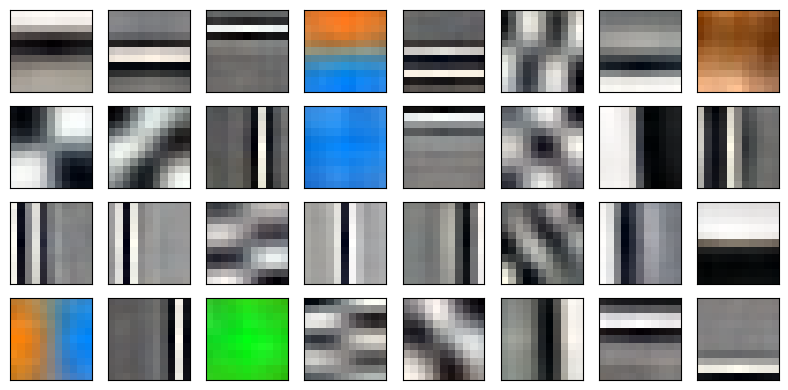

4000/4000 [==============================] - 7s 2ms/step - max: 30.3078 - min: -25.9532 - var: 10.4118 - loss: 28.2135
Epoch 2/3
3967/4000 [============================>.] - ETA: 0s - max: 30.4381 - min: -26.0610 - var: 10.4813 - loss: 25.5543

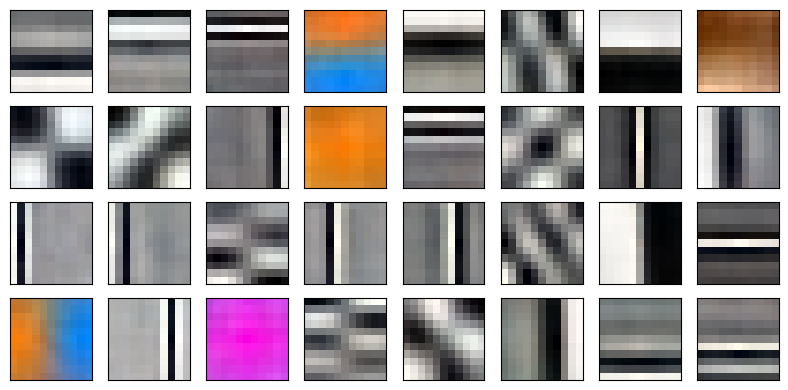

4000/4000 [==============================] - 6s 2ms/step - max: 30.4093 - min: -26.0678 - var: 10.4893 - loss: 25.5591
Epoch 3/3
3970/4000 [============================>.] - ETA: 0s - max: 30.6072 - min: -25.1943 - var: 10.4797 - loss: 25.5504

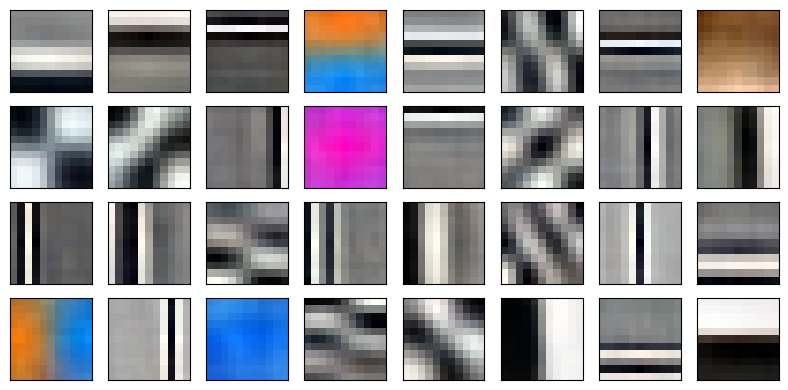

4000/4000 [==============================] - 6s 2ms/step - max: 30.5768 - min: -25.2040 - var: 10.4852 - loss: 25.5506


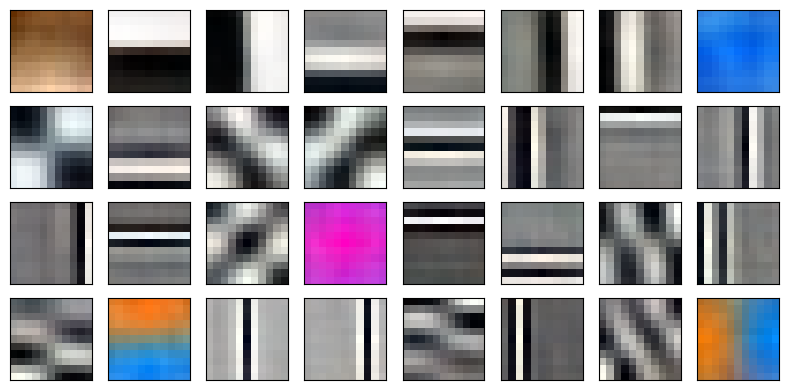

In [37]:
tf.keras.backend.clear_session()


def scaled_tanh(x, s=4.0):
    return s * tf.nn.tanh(x / s)


dense = RecDense(
    config.num_filters,
    kernel_initializer=keras.initializers.Orthogonal(),
    activation=scaled_tanh,
    kernel_constraint=keras.constraints.UnitNorm([0]),
    use_bias=False,
)
model = ModelCustom(dense=dense, name=name)
model.compile(tf.keras.optimizers.Adam(1e-2))
model.fit(ds, epochs=config.epochs, callbacks=[PlotFilters()])
model.plot_filters(sort_by="moving_variance", sort=True)

In [38]:
y = tf.matmul(data, dense.kernel)
y = y / tf.sqrt(dense.moving_variance)

indices = tf.argsort(dense.moving_variance, direction="DESCENDING")
y = tf.gather(y, indices, axis=1)
y = tf.random.shuffle(y)

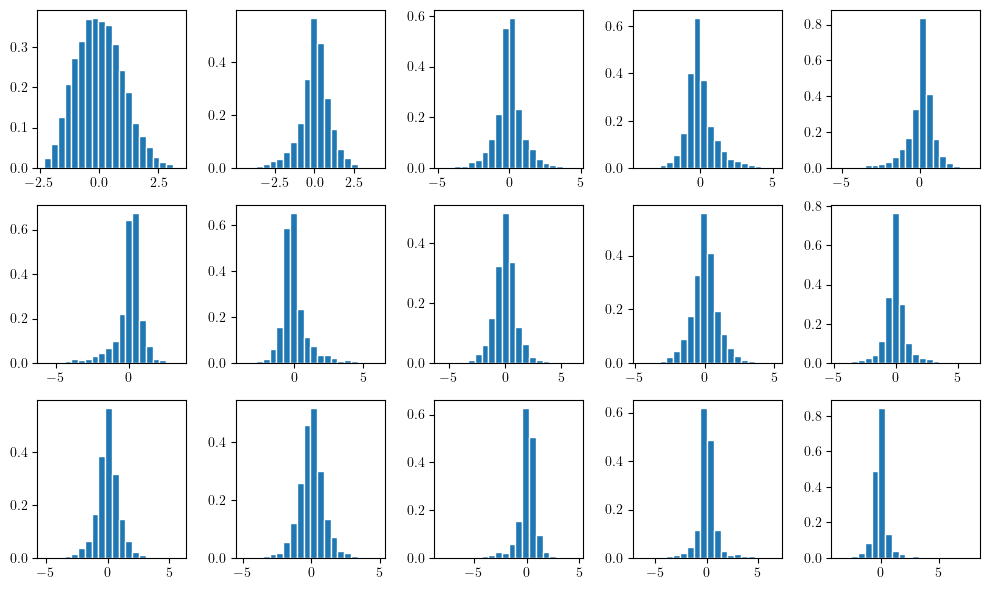

In [39]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 6))
for i, ax in enumerate(axes.flatten()):
    ax.hist(y[:4000, i], bins=20, density=True, ec="white")

plt.tight_layout()

plt.savefig(f"{ROOT_DIR}/{config.prefix}-hist.jpg", dpi=300, bbox_inches="tight")

# FastICA

In [40]:
name = "ica-fast"

In [41]:
ica = FastICA(config.num_filters, whiten="unit-variance").fit(data)

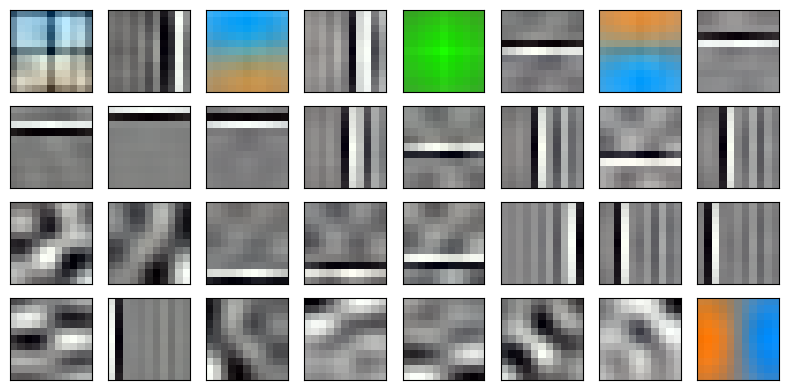

In [42]:
kernel = ica.components_.T
kernel0 = kernel
n = np.sqrt(np.sum(kernel**2, axis=0))
s = np.dot(data, kernel / n).std(0)

kernel = kernel[:, np.argsort(s)[::-1]]
kernel = kernel / tf.sqrt(tf.reduce_sum(tf.square(kernel), axis=0))
s = np.dot(data, kernel).std(0)
kernel = tf.reshape(kernel, config.kernel_shape)
plot_and_save(kernel, name=name)

check that the overall transformation is not exactly orthogonal

In [43]:
wtw = tf.matmul(kernel0, kernel0, transpose_a=True)
a = wtw - tf.linalg.band_part(wtw, 0, 0)
tf.reduce_sum(tf.abs(a))

<tf.Tensor: shape=(), dtype=float64, numpy=22.09404130400728>

# Linear and nonlinear PCA on ZCA-whitened data

Here we first perform linear PCA to use as a ZCA-whitening transformation.

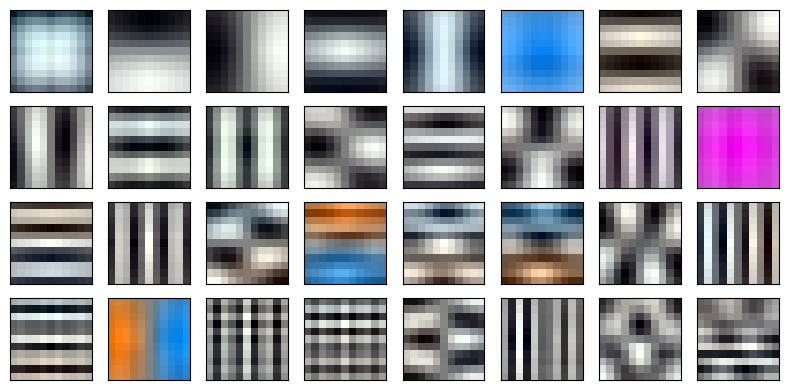

In [44]:
pca = PCA(config.num_filters).fit(data)
kernel = tf.reshape(pca.components_.T, config.kernel_shape)
plot_and_save(kernel, name="pca")

In [45]:
y = tf.matmul(data, tf.cast(pca.components_.T,tf.float32))
std = tf.math.reduce_std(y,axis=0)
y = y/std + 0.001*tf.random.normal(tf.shape(y)) # add a bit of noise
data_zca = tf.matmul(y, tf.cast(pca.components_.T,tf.float32),transpose_b=True)


Linear PCA is not able to eliminate the rotational indeterminancy over the entire space because all the components now have unit variance.

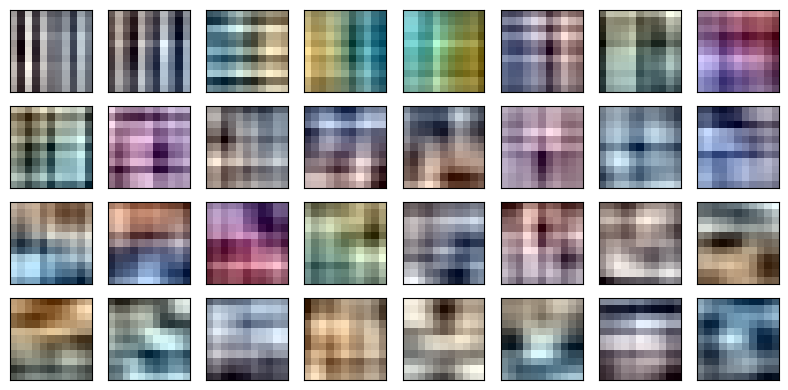

In [46]:
pca2 = PCA(config.num_filters).fit(data_zca)
kernel2 = tf.reshape(pca2.components_.T, config.kernel_shape)
plot_and_save(kernel2, name="pca-white-svd")

In [47]:
tf.keras.backend.clear_session()


class RecDense(layers.Dense):
    def build(self, input_shape):
        super().build(input_shape)
        self.moving_variance = self.add_weight(
            "var", shape=self.units, initializer="ones", trainable=False
        )

    def call(self, inputs, training=None):
        if training is None:
            training = keras.backend.learning_phase()
        kernel = self.kernel

        inputs = inputs - tf.reduce_mean(inputs, axis=0)

        y = tf.matmul(inputs, kernel)
        if training:
            var = tf.math.reduce_variance(y, axis=0)
            self.moving_variance.assign_add(0.01 * (var - self.moving_variance))

            std = tf.sqrt(1e-3 + self.moving_variance)

            yr = std * self.activation(y / std)

            loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.square(
                        tf.matmul(yr, tf.stop_gradient(kernel), transpose_b=True)
                        - inputs
                    ),
                    axis=1,
                )
            )
            self.add_loss(loss)

        if self.use_bias:
            y += self.bias
        return y

Nonlinear PCA on ZCA-whitened data recovers the same filters as FastICA

Epoch 1/3
3967/4000 [============================>.] - ETA: 0s - loss: 3.8360

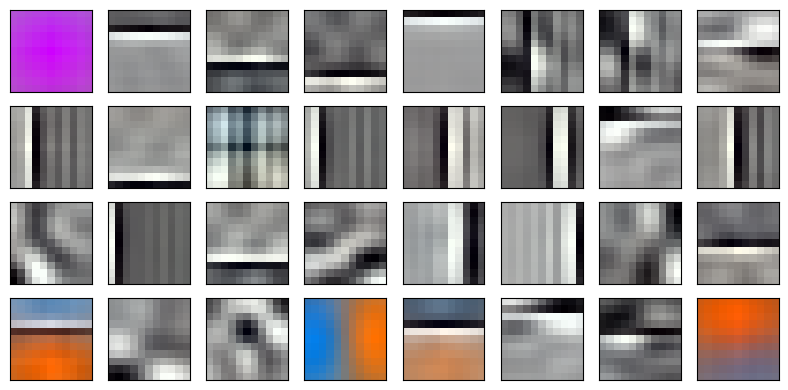

4000/4000 [==============================] - 6s 1ms/step - loss: 3.8207
Epoch 2/3
3981/4000 [============================>.] - ETA: 0s - loss: 2.0641

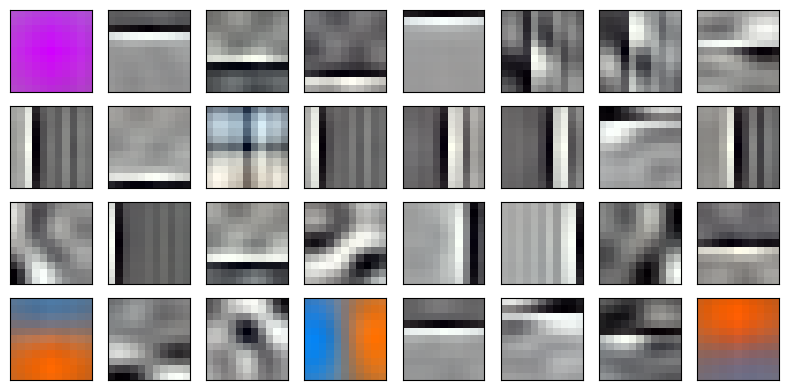

4000/4000 [==============================] - 5s 1ms/step - loss: 2.0647
Epoch 3/3
3950/4000 [============================>.] - ETA: 0s - loss: 2.0792

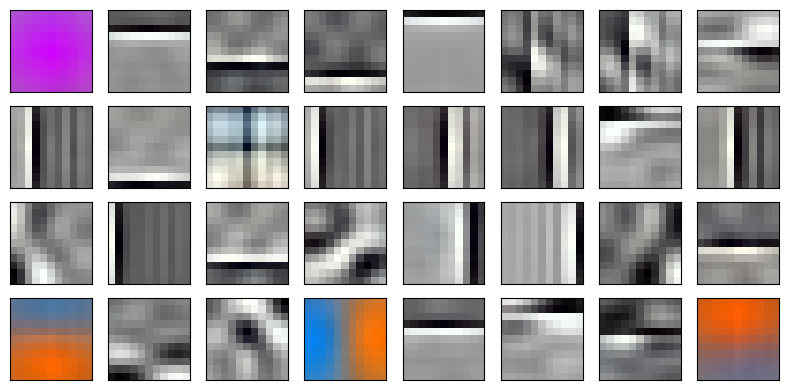

4000/4000 [==============================] - 5s 1ms/step - loss: 2.0794


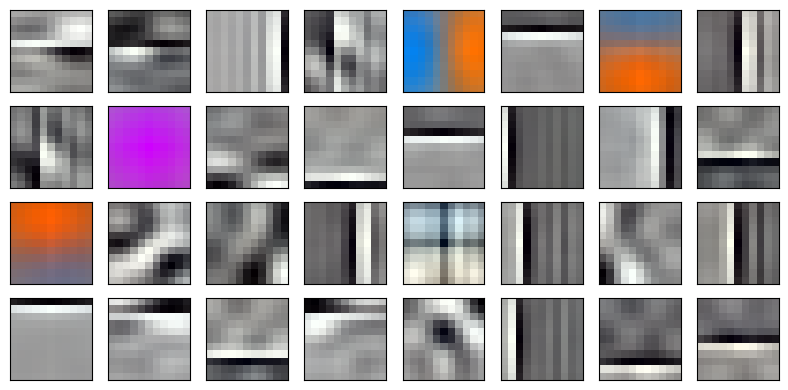

In [48]:
tf.keras.backend.clear_session()


def scaled_tanh(x, s=4.0):
    return s * tf.nn.tanh(x / s)


dense = RecDense(
    config.num_filters,
    kernel_initializer=keras.initializers.Orthogonal(),
    activation=scaled_tanh,
    kernel_constraint=keras.constraints.UnitNorm([0]),
    use_bias=False,
)
model = ModelCustom(dense=dense, name=name)
model.compile(tf.keras.optimizers.SGD(1e-2, 0.9))
model.fit(data_zca, batch_size=config.batch_size, epochs=config.epochs, callbacks=[PlotFilters()])
model.plot_filters(sort_by="moving_variance", sort=True)